# BBBC comparison

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [4]:
import pickle

In [5]:
data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021")

data_dir1 = data_root / "scip" / "illum_correction" / "allweeks_dapi"
path1 = data_dir1 / "features.parquet"

data_dir2 = data_root / "scip" / "no_correction"
path2 = data_dir2.rglob("features.parquet")

data_dir3 = data_root / "scip" / "illum_correction" / "allweeks_specific"
path3 = data_dir3 / "features.parquet"

moa_path = data_root / "BBBC021_v1_moa.csv"
image_path = data_root / "BBBC021_v1_image.csv"

In [6]:
moa = pandas.read_csv(moa_path)
image = pandas.read_csv(image_path)

In [7]:
moa_image = moa.merge(
    image,
    left_on=["compound", "concentration"],
    right_on=["Image_Metadata_Compound", "Image_Metadata_Concentration"]
).drop(columns=["Image_Metadata_Compound", "Image_Metadata_Concentration"])

In [8]:
moa_image["batch"] = moa_image["Image_Metadata_Plate_DAPI"].apply(lambda p: int(p.split("_")[0][len("Week"):])).astype('category')

In [9]:
moa_image.columns = ["meta_" + c for c in moa_image.columns]

In [10]:
%%time
df1 = pq.read_table(path1).to_pandas()

CPU times: user 13 s, sys: 10.9 s, total: 23.9 s
Wall time: 41.6 s


In [11]:
df1 = df1.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

In [ ]:
dfs = []
for p in path2:
    print(p)
    tmp = pq.read_table(p).to_pandas()
    print(tmp.shape)
    dfs.append(tmp)
df2 = pandas.concat(dfs)
del dfs

/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/scip/no_correction/040620221255_Week3/features.parquet
(241819, 685)
/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/scip/no_correction/310520220930_Week2/features.parquet
(150325, 677)
/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/scip/no_correction/040620221255_Week4-5/features.parquet
(522114, 677)
/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/scip/no_correction/050820221649_Week8-10/features.parquet


In [ ]:
df2 = df2.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

In [12]:
%%time
df3 = pq.read_table(path3).to_pandas()

CPU times: user 11 s, sys: 9.38 s, total: 20.4 s
Wall time: 35.2 s


In [13]:
df3 = df3.merge(moa_image, left_on="meta_filename", right_on="meta_Image_FileName_DAPI")

In [14]:
plate_counts = (
    df1
    .groupby("meta_Image_Metadata_Plate_DAPI")
    .size()
    .to_frame()
#     .merge(df2.groupby("meta_Image_Metadata_Plate_DAPI").size().to_frame(), left_index=True, right_index=True)
    .merge(df3.groupby("meta_Image_Metadata_Plate_DAPI").size().to_frame(), left_index=True, right_index=True)
)
plate_counts.columns = ["illum_corr", "illum_corr_actin"]

In [15]:
plate_counts["diff"] = (plate_counts["illum_corr"] - plate_counts["illum_corr_actin"])

In [16]:
plate_counts["diff"].idxmax()

'Week10_40111'

In [17]:
plate_counts["diff"].loc[plate_counts["diff"].idxmax()]

4201

In [21]:
well_counts = (
    df1
    .groupby(["meta_Image_Metadata_Plate_DAPI", "meta_Image_Metadata_Well_DAPI"])
    .size()
    .to_frame()
#     .merge(df2.groupby("meta_Image_Metadata_Plate_DAPI").size().to_frame(), left_index=True, right_index=True)
    .merge(df3.groupby(["meta_Image_Metadata_Plate_DAPI", "meta_Image_Metadata_Well_DAPI"]).size().to_frame(), left_index=True, right_index=True)
)
well_counts.columns = ["illum_corr", "illum_corr_actin"]

In [23]:
well_counts["diff"] = (well_counts["illum_corr"] - well_counts["illum_corr_actin"])

In [26]:
well_counts["diff"].idxmax(), well_counts["diff"].loc[well_counts["diff"].idxmax()]

(('Week10_40119', 'F11'), 723)

In [34]:
well_counts.loc[well_counts["diff"].idxmax()]

illum_corr          1851
illum_corr_actin    1128
diff                 723
Name: (Week10_40119, F11), dtype: int64

In [30]:
F11 = image[(image["Image_Metadata_Plate_DAPI"] == 'Week10_40119') & (image["Image_Metadata_Well_DAPI"] == 'F11')]

In [35]:
F11

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
11944,0,677,Week10_200907_F11_s1_w1968B98EC-BBA5-4CEB-A421...,Week10/Week10_40119,Week10_200907_F11_s1_w29E4857B1-BD7F-4555-9790...,Week10/Week10_40119,Week10_200907_F11_s1_w41ECA3A04-6DA5-47B6-81CB...,Week10/Week10_40119,Week10_40119,F11,3,DMSO,0.0
11945,0,678,Week10_200907_F11_s2_w17A42E2D3-4C5A-4010-82A7...,Week10/Week10_40119,Week10_200907_F11_s2_w2835DBB94-2F9C-473E-8F93...,Week10/Week10_40119,Week10_200907_F11_s2_w4B33D19DD-4E7E-4C0F-BB4E...,Week10/Week10_40119,Week10_40119,F11,3,DMSO,0.0
11946,0,679,Week10_200907_F11_s3_w1EB4A687C-756C-4F75-A836...,Week10/Week10_40119,Week10_200907_F11_s3_w26867E07A-500F-4850-BC43...,Week10/Week10_40119,Week10_200907_F11_s3_w44CA481EC-A46D-48E6-BC91...,Week10/Week10_40119,Week10_40119,F11,3,DMSO,0.0
11947,0,680,Week10_200907_F11_s4_w1F03C3E93-7B44-41F1-B96A...,Week10/Week10_40119,Week10_200907_F11_s4_w235F0E888-5123-4808-88D8...,Week10/Week10_40119,Week10_200907_F11_s4_w4AD7AFE4E-FD25-43AD-A6E5...,Week10/Week10_40119,Week10_40119,F11,3,DMSO,0.0


In [27]:
with open(data_dir1 / "correction_images.pickle", "rb") as fh:
    total = pickle.load(fh)

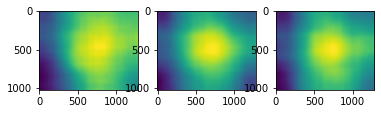

In [37]:
fig, axes = plt.subplots(1, 3)
for ax, c in zip(axes, total['Week10_40111']):
    ax.imshow(c.T)

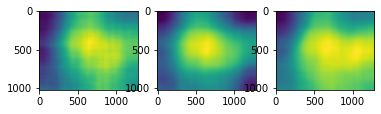

In [38]:
fig, axes = plt.subplots(1, 3)
for ax, c in zip(axes, total['Week10_40115']):
    ax.imshow(c.T)

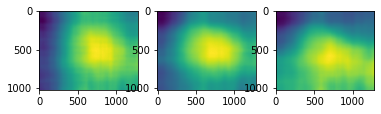

In [39]:
fig, axes = plt.subplots(1, 3)
for ax, c in zip(axes, total['Week10_40119']):
    ax.imshow(c.T)